In [ ]:
# Import the Matplotlib library for creating graphs and visualizations
import matplotlib.pyplot as plt

# Import NumPy for working with numbers, arrays, and mathematical operations
import numpy as np

# Import PIL (Python Imaging Library) for opening, editing, and saving images
import PIL

# Import TensorFlow, a deep learning framework for building AI/ML models
import tensorflow as tf

# From TensorFlow, import Keras, which is a high-level API for building deep learning models
from tensorflow import keras

# From Keras, import the 'layers' module to create different layers for the neural network
from tensorflow.keras import layers

# From Keras, import 'Sequential', a model type where layers are stacked one after another
from tensorflow.keras.models import Sequential

# Import the pathlib library to work with file and folder paths easily
import pathlib

In [ ]:
# Store the dataset URL (link to a zipped file of flower images) in a variable
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [ ]:
# Download the dataset from the URL, give it the name 'flower_photos',
# and automatically unzip it (untar=True)
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Convert the downloaded dataset path into a Path object for easy file handling,
# then go inside the "flower_photos" folder
data_dir = pathlib.Path(data_dir) / "flower_photos"


In [ ]:
# Count the number of .jpg image files inside all subfolders of 'flower_photos'
image_count = len(list(data_dir.glob('*/*.jpg')))

In [ ]:
# Print the total number of images found
print(image_count)

3670


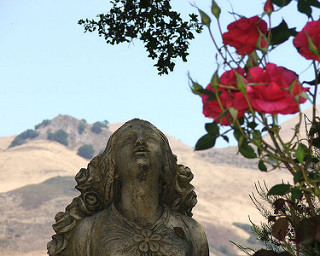

In [ ]:
# Get a list of all image file paths inside the 'roses' folder
roses = list(data_dir.glob('roses/*'))

# Open and display the first rose image
PIL.Image.open(str(roses[0]))

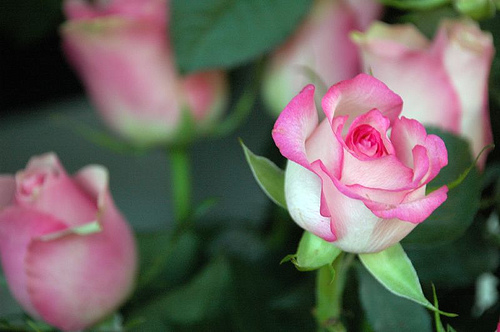

In [ ]:
# Open and display the second rose image
PIL.Image.open(str(roses[1]))

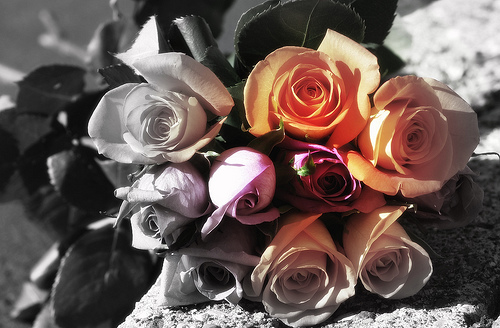

In [ ]:
# Open and display the second rose image
PIL.Image.open(str(roses[3]))

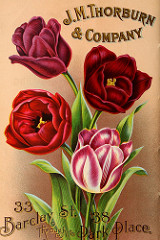

In [ ]:
# Get a list of all image file paths inside the 'tulips' folder
tulips = list(data_dir.glob('tulips/*'))

# Open and display the first tulip image
PIL.Image.open(str(tulips[0]))

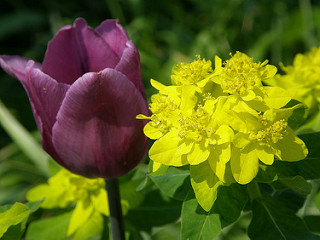

In [ ]:
PIL.Image.open(str(tulips[5]))

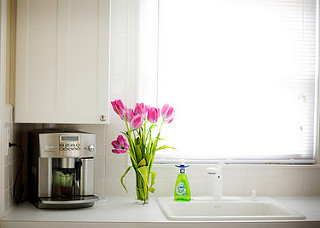

In [ ]:
# Open and display the second tulip image
PIL.Image.open(str(tulips[1]))

In [ ]:
# Set the number of images to load in each batch during training
batch_size = 32

# Set the target height (in pixels) for each image
img_height = 180

# Set the target width (in pixels) for each image
img_width = 180

In [ ]:
# ---------------------- TRAINING DATASET ----------------------

# Create a training dataset from images in 'data_dir'
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,               # Path to the main dataset folder
    validation_split=0.2,   # Use 20% of the data for validation, 80% for training
    subset="training",      # Specify that this is the training subset
    seed=123,               # Random seed for reproducibility (same split every time)
    image_size =(img_height, img_width),  # Resize all images to 180x180 pixels
    batch_size= batch_size   # Number of images to load in each batch
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# ---------------------- VALIDATION DATASET ----------------------

# Create a validation dataset from images in 'data_dir'
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,               # Path to the main dataset folder
    validation_split=0.2,   # Use the same 20% split for validation
    subset="validation",    # Specify that this is the validation subset
    seed=123,               # Same random seed to ensure matching split
    image_size= (img_height, img_width),  # Resize all images to 180x180 pixels
    batch_size= batch_size   # Number of images to load in each batch
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# Get the list of class (folder) names from the training dataset
class_names = train_ds.class_names

# Print the list of class names (e.g., ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


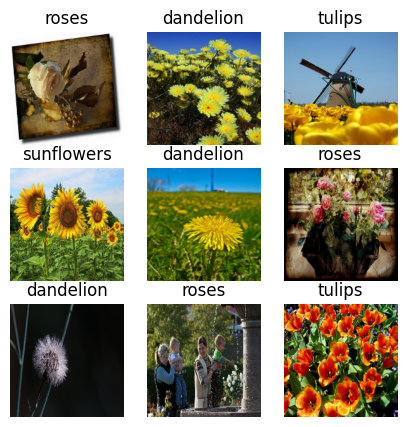

In [ ]:
# ---------------- VISUALIZE SAMPLE IMAGES ----------------

# Set the size of the figure to 10x10 inches
plt.figure(figsize=(5, 5))

# Take one batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
  # Loop through the first 9 images in the batch
    for i in range(9):
        # Create a subplot (3 rows × 3 columns) for each image
        ax = plt.subplot(3, 3, i + 1)

        # Show the image (convert tensor to NumPy array, then to uint8 type for display)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the image as its class name
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for a cleaner look
        plt.axis("off")


In [ ]:
# ---------------- CHECK BATCH SHAPE ----------------

# Loop through the training dataset and print the shape of the image and label batches
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)   # e.g., (32, 180, 180, 3) → 32 images of size 180x180 with 3 color channels
    print(labels_batch.shape)  # e.g., (32,) → 32 labels for the batch
    break                      # Only check the first batch

(32, 180, 180, 3)
(32,)


In [ ]:
# ---------------- OPTIMIZE DATA PIPELINE ----------------

# Set TensorFlow to automatically tune performance for data loading
AUTOTUNE = tf.data.AUTOTUNE

# Cache data in memory for faster training, shuffle training data, and prefetch for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch validation data (no shuffle needed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# ---------------- NORMALIZE IMAGE PIXEL VALUES ----------------

# Create a normalization layer to scale pixel values from [0,255] to [0,1]
normalization_layer = layers.Rescaling(1./255)

# Apply normalization to each batch in the training dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Get one batch from the normalized dataset
image_batch, labels_batch = next(iter(normalized_ds))

# Select the first image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values to confirm they are now between 0 and 1
print(np.min(first_image),"------", np.max(first_image))

0.0 ------ 1.0


In [ ]:
# Get the number of classes (categories) from the dataset
num_classes = len(class_names)
num_classes

5

In [ ]:
# ---------------- BUILD THE CNN MODEL ----------------

model = Sequential([

    # Step 1: Normalize image pixel values from [0, 255] to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Step 2: First convolutional layer
    # - 16 filters, each of size 3x3
    # - 'same' padding → output size remains the same as input
    # - 'relu' activation for non-linearity
    layers.Conv2D(16, 3, padding='same', activation='relu'),

    # Step 3: First max pooling layer (reduces spatial size)
    layers.MaxPooling2D(),

    # Step 4: Second convolutional layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),

    # Step 5: Second max pooling layer
    layers.MaxPooling2D(),

    # Step 6: Third convolutional layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),

    # Step 7: Third max pooling layer
    layers.MaxPooling2D(),

    # Step 8: Flatten the 3D feature maps into 1D vector for Dense layers
    layers.Flatten(),

    # Step 9: Fully connected layer with 128 neurons
    layers.Dense(128, activation='relu'),

    # Step 10: Output layer
    # - 'num_classes' neurons (one for each category)
    # - No activation because we’ll use `from_logits=True` in loss function
    layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# ---------------- COMPILE THE MODEL ----------------

model.compile(
    optimizer='adam',  # Adam optimizer for adaptive learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # For integer labels
    metrics=['accuracy']  # Track accuracy during training
)

In [ ]:
# ---------------- MODEL SUMMARY ----------------

# Print a summary of the model architecture and parameter counts
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set the number of times (epochs) the model will see the entire training dataset
epochs = 10

# Train the model
history = model.fit(
    train_ds,             # Training dataset
    validation_data=val_ds, # Validation dataset to check performance after each epoch
    epochs=epochs           # Number of training epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.3539 - loss: 1.5708 - val_accuracy: 0.5477 - val_loss: 1.1127
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5793 - loss: 1.0294 - val_accuracy: 0.6090 - val_loss: 0.9729
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6822 - loss: 0.8007 - val_accuracy: 0.5995 - val_loss: 1.0363
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7682 - loss: 0.6107 - val_accuracy: 0.6390 - val_loss: 0.9832
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8695 - loss: 0.3859 - val_accuracy: 0.6471 - val_loss: 1.0254
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9321 - loss: 0.2221 - val_accuracy: 0.6512 - val_loss: 1.2044
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9538 - loss: 0.1389 - val_accuracy: 0.6281 - val_loss: 1.3608
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9843 - loss: 0.0661 - val_accuracy: 0.6022 -

In [ ]:
# ---------------- GET TRAINING RESULTS ----------------

# Get training accuracy values from history
acc = history.history['accuracy']

# Get validation accuracy values from history
val_acc = history.history['val_accuracy']

# Get training loss values from history
loss = history.history['loss']

# Get validation loss values from history
val_loss = history.history['val_loss']

In [ ]:
print(acc, "----", val_acc, "----",loss, "----", val_loss )

[0.4349454939365387, 0.6059264540672302, 0.6866484880447388, 0.7775885462760925, 0.8620572090148926, 0.9315395355224609, 0.9489100575447083, 0.9826294183731079, 0.9904631972312927, 0.9986376166343689] ---- [0.5476838946342468, 0.608991801738739, 0.5994550585746765, 0.6389645934104919, 0.6471389532089233, 0.6512261629104614, 0.6280654072761536, 0.6021798253059387, 0.6512261629104614, 0.6457765698432922] ---- [1.3360157012939453, 0.9917619824409485, 0.797060489654541, 0.5809626579284668, 0.3870367705821991, 0.20925608277320862, 0.1489275097846985, 0.06571996212005615, 0.040532439947128296, 0.012641919776797295] ---- [1.1126775741577148, 0.9729376435279846, 1.036301612854004, 0.9831574559211731, 1.0253653526306152, 1.2043615579605103, 1.3608306646347046, 1.7766791582107544, 1.8254640102386475, 2.0149316787719727]


In [ ]:
max(acc)

0.9986376166343689

In [ ]:
max(val_acc)

0.6512261629104614

In [ ]:
max(loss)

1.3360157012939453

In [ ]:
max(val_loss)

2.0149316787719727

Text(0.5, 1.0, 'Training and Validation Accuracy')

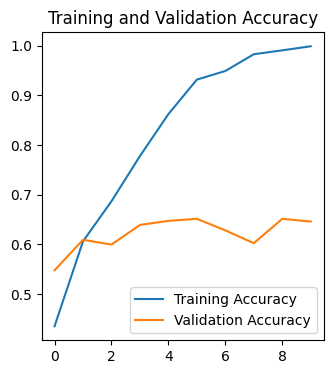

In [ ]:
# ---------------- PLOT ACCURACY AND LOSS ----------------

# Create a range of epoch numbers for plotting
epochs_range = range(epochs)

# Set the figure size for the plots
plt.figure(figsize=(8, 4))

# -------- Plot 1: Training vs Validation Accuracy --------
plt.subplot(1, 2, 1)                       # First subplot in a 1x2 grid
plt.plot(epochs_range, acc, label='Training Accuracy')   # Training accuracy line
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Validation accuracy line
plt.legend(loc='lower right')              # Place legend at the bottom right
plt.title('Training and Validation Accuracy')  # Title for the plot

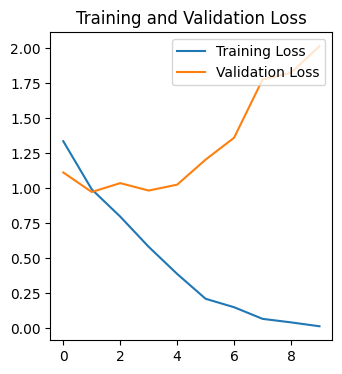

In [ ]:
# -------- Plot 2: Training vs Validation Loss --------
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 2)                       # Second subplot in a 1x2 grid
plt.plot(epochs_range, loss, label='Training Loss')       # Training loss line
plt.plot(epochs_range, val_loss, label='Validation Loss') # Validation loss line
plt.legend(loc='upper right')              # Place legend at the top right
plt.title('Training and Validation Loss')  # Title for the plot

# Show both plots
plt.show()

In [ ]:
# ---------------- CREATE DATA AUGMENTATION LAYERS ----------------

# Create a Sequential model for applying random image transformations
data_augmentation = keras.Sequential([

    # Randomly flip the image horizontally (left ↔ right)
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),

    # Randomly rotate the image by up to 10% of the total rotation
    layers.RandomRotation(0.2),

    # Randomly zoom into the image by up to 10%
    layers.RandomZoom(0.2),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


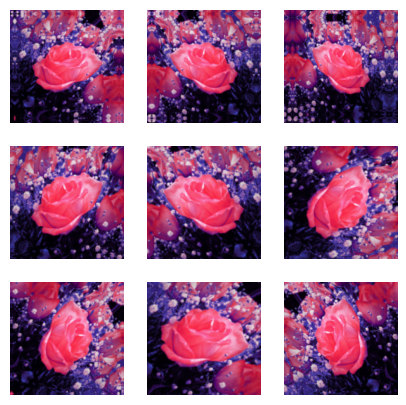

In [ ]:
# ---------------- VISUALIZE AUGMENTED IMAGES ----------------

# Create a figure with a size of 10x10 inches
plt.figure(figsize=(5, 5))

# Take one batch of images from the training dataset
for images, _ in train_ds.take(1):

    # Loop through the first 9 images to visualize augmentation
    for i in range(9):

        # Apply the data augmentation transformations to the images
        augmented_images = data_augmentation(images)

        # Create a subplot (3 rows × 3 columns)
        ax = plt.subplot(3, 3, i + 1)

        # Show the first augmented image from the batch
        plt.imshow(augmented_images[0].numpy().astype("uint8"))

        # Remove axis ticks for a cleaner view
        plt.axis("off")

In [ ]:
# ---------------- BUILD CNN MODEL WITH DATA AUGMENTATION ----------------

model1 = Sequential([

    # Step 1: Apply random image transformations (flip, rotate, zoom) for better generalization
    data_augmentation,

    # Step 2: Normalize pixel values from [0, 255] to [0, 1]
    layers.Rescaling(1./255),

    # Step 3: First convolutional layer
    # - 16 filters of size 3x3
    # - 'same' padding keeps image size unchanged
    # - 'relu' activation adds non-linearity
    layers.Conv2D(16, 3, padding='same', activation='relu'),

    # Step 4: First max pooling layer (reduces spatial size)
    layers.MaxPooling2D(),

    # Step 5: Second convolutional layer with 32 filters
    layers.Conv2D(32, 3, padding='same', activation='relu'),

    # Step 6: Second max pooling layer
    layers.MaxPooling2D(),

    # Step 7: Third convolutional layer with 64 filters
    layers.Conv2D(64, 3, padding='same', activation='relu'),

    # Step 8: Third max pooling layer
    layers.MaxPooling2D(),

    # Step 9: Dropout layer (drops 20% of neurons randomly to prevent overfitting)
    layers.Dropout(0.3),

    # Step 10: Flatten 3D feature maps into a 1D vector
    layers.Flatten(),

    # Step 11: Fully connected layer with 128 neurons
    layers.Dense(128, activation='relu'),

    # Step 12: Output layer
    # - 'num_classes' neurons (one for each category)
    # - Named "outputs" for clarity
    layers.Dense(num_classes, name="outputs")
])

In [ ]:
# ---------------- COMPILE THE MODEL ----------------

model1.compile(
    optimizer='adam',  # Adam optimizer for adaptive learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Loss for integer labels
    metrics=['accuracy']  # Track accuracy during training
)

In [ ]:
# ---------------- MODEL SUMMARY ----------------

# Print a summary of the model architecture and parameters
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Set the number of times (epochs) the model will see the entire training dataset
epochs = 10

# Train the model
history = model1.fit(
    train_ds,             # Training dataset
    validation_data=val_ds, # Validation dataset to check performance after each epoch
    epochs=epochs           # Number of training epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.3426 - loss: 1.4899 - val_accuracy: 0.4619 - val_loss: 1.3556
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5272 - loss: 1.1258 - val_accuracy: 0.6185 - val_loss: 1.0365
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6172 - loss: 0.9591 - val_accuracy: 0.6322 - val_loss: 0.9567
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6370 - loss: 0.9178 - val_accuracy: 0.6635 - val_loss: 0.9184
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6833 - loss: 0.8247 - val_accuracy: 0.6703 - val_loss: 0.8348
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6837 - loss: 0.8183 - val_accuracy: 0.6839 - val_loss: 0.8472
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6966 - loss: 0.7846 - val_accuracy: 0.6948 - val_loss: 0.8008
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7137 - loss: 0.7629 - val_accuracy: 0.6771 - v

In [ ]:
# ---------------- GET TRAINING HISTORY METRICS ----------------

# Extract training accuracy values from the training history
acc = history.history['accuracy']

# Extract validation accuracy values from the training history
val_acc = history.history['val_accuracy']

# Extract training loss values from the training history
loss = history.history['loss']

# Extract validation loss values from the training history
val_loss = history.history['val_loss']

In [ ]:
max(acc)

0.7183242440223694

In [ ]:
max(val_acc)

0.6948229074478149

In [ ]:
max(loss)

1.309619665145874

In [ ]:
max(val_loss)

1.3556346893310547

Text(0.5, 1.0, 'Training and Validation Accuracy')

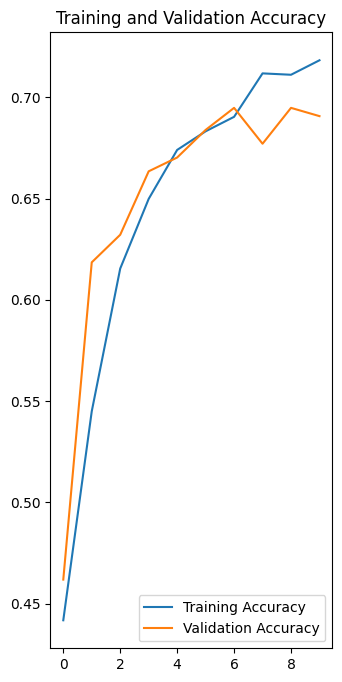

In [ ]:
# ---------------- PLOT TRAINING & VALIDATION METRICS ----------------

# Create a range of numbers from 0 to epochs-1 for the x-axis
epochs_range = range(epochs)

# Create a figure with size 8x8 inches
plt.figure(figsize=(8, 8))


# --------- Plot 1: Training vs Validation Accuracy ---------
plt.subplot(1, 2, 1)  # First plot in a 1x2 grid
plt.plot(epochs_range, acc, label='Training Accuracy')        # Training accuracy line
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Validation accuracy line
plt.legend(loc='lower right')  # Show legend at the bottom right
plt.title('Training and Validation Accuracy')  # Add plot title

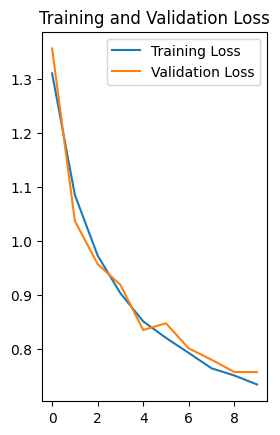

In [ ]:
# --------- Plot 2: Training vs Validation Loss ---------
plt.subplot(1, 2, 2)  # Second plot in a 1x2 grid
plt.plot(epochs_range, loss, label='Training Loss')           # Training loss line
plt.plot(epochs_range, val_loss, label='Validation Loss')     # Validation loss line
plt.legend(loc='upper right')  # Show legend at the top right
plt.title('Training and Validation Loss')  # Add plot title


# Show both plots together
plt.show()

In [ ]:
## Predict on new data
#Use your model to classify an image that wasn't included in the training or validation sets.
#Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
# Store the URL of the sunflower image in a variable
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"

# Download the image from the given URL and save it locally with the name 'Red_sunflower'
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Load the sunflower image from the given path
# Resize it to match the model's expected input size (img_height x img_width)
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

# Convert the loaded image into a NumPy array so it can be processed by the model
img_array = tf.keras.utils.img_to_array(img)

# Check the shape of the image array (should be: height, width, color_channels)
img_array.shape

# (This line repeats the shape check — it will show the same result again)
img_array.shape


(180, 180, 3)

In [ ]:
# Expand dimensions to make it (1, img_height, img_width, 3)
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
predictions = model.predict(img_array)

# Convert raw scores to probabilities
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
This image most likely belongs to daisy with a 21.72 percent confidence.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

# -----------------------------------------------------------
# 1️⃣ Define list of image URLs or local file paths
# -----------------------------------------------------------
image_paths = [
    "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg",
    "https://t3.ftcdn.net/jpg/01/05/57/38/240_F_105573812_cvD4P5jo6tMPhZULX324qUYFbNpXlisD.jpg"
]

# -----------------------------------------------------------
# 2️⃣ Download images if they are URLs, otherwise use local paths
# -----------------------------------------------------------
local_paths = []
for path in image_paths:
    if path.startswith("http"):  # If it's a web URL, download it
        local_paths.append(tf.keras.utils.get_file(origin=path))
    else:  # If it's already a local file path
        local_paths.append(path)

# -----------------------------------------------------------
# 3️⃣ Preprocess all images: resize and convert to arrays
# -----------------------------------------------------------
img_arrays = []
for path in local_paths:
    # Load and resize image to model's expected input size
    img = load_img(path, target_size=(img_height, img_width))

    # Convert image to NumPy array (pixel values 0–255)
    img_array = img_to_array(img)

    # Append to list
    img_arrays.append(img_array)

# -----------------------------------------------------------
# 4️⃣ Create a batch (4D array) and normalize pixel values (0–1)
# -----------------------------------------------------------
# Shape will be: (number_of_images, img_height, img_width, 3)
img_batch = np.array(img_arrays) / 255.0

# -----------------------------------------------------------
# 5️⃣ Use the trained model to predict on the batch
# -----------------------------------------------------------
predictions = model.predict(img_batch)

# -----------------------------------------------------------
# 6️⃣ Display prediction results for each image
# -----------------------------------------------------------
for i, prediction in enumerate(predictions):
    # Apply softmax to get probability distribution
    score = tf.nn.softmax(prediction)

    # Find class with highest probability
    predicted_class = class_names[np.argmax(score)]

    # Print result with confidence percentage
    print(
        f"Image {i+1} most likely belongs to {predicted_class} "
        f"with a {100 * np.max(score):.2f}% confidence."
    )


21023/21023 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Image 1 most likely belongs to daisy with a 20.01% confidence.
Image 2 most likely belongs to daisy with a 20.01% confidence.
Image 3 most likely belongs to daisy with a 20.01% confidence.
Image 4 most likely belongs to daisy with a 20.01% confidence.
